Label: 4


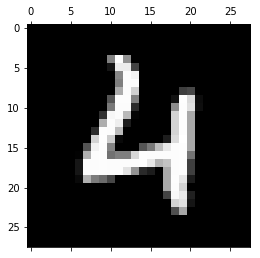

<function __main__.show_image>

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
from pylab import *
import scipy
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import itertools

dataset=pd.read_csv('train.csv', sep=',',header=0)
label=list(dataset.label)
data=dataset.iloc[:,1:]
def show_image(n):
    print("Label:",label[n])
    t= data.iloc[n].values.reshape(28,28)
    plt.matshow(t, cmap='gray')
    plt.show()
interact(show_image,n=(0,41999))


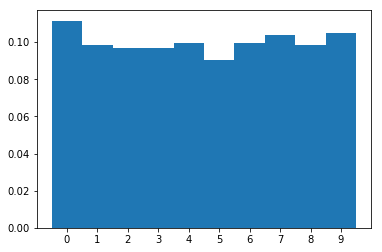

In [56]:
from collections import Counter
def show_prior_prob():
    labels, counts = zip(*Counter(label).items())
    total = sum(counts)
    pp = list(map(lambda x: x/float(total), counts))
    sorted_pp = [pp for _,pp in sorted(zip(labels,pp))]
    plt.bar(labels,sorted_pp,1)
    plt.xticks(arange(10),arange(10))
    plt.show()
show_prior_prob()


In [6]:
def mostNearestNeighbor(inX, dataMat, labelMat):
    dataSetSize = dataMat.shape[0]
    diffMat = tile(inX,(dataSetSize,1)) - dataMat
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = list(sqDistances**0.5)
    targetIndex = distances.index(min(distances))
    return min(distances),targetIndex, label[targetIndex]

def findUniqDigitsIndex():
    res = []
    for i in range(10):
        res.append(label.index(i))
    return res

def findNearestNeighborQuestion():
    for i in findUniqDigitsIndex():
        dataRemain = np.delete(array(data),(i), axis=0)
        labelRemain = np.delete(array(label),(i), axis=0)
        minDistance, predictedIndex, predictedValue = mostNearestNeighbor(data.iloc[i],dataRemain,labelRemain)
        print("Predicted Value :" + str(predictedValue) + " Actual value :" + str(label[i]))
        if str(predictedValue)!=str(label[i]):
            print("*")
findNearestNeighborQuestion()

Predicted Value :1 Actual value :0
*
Predicted Value :7 Actual value :1
*
Predicted Value :9 Actual value :2
*
Predicted Value :4 Actual value :3
*
Predicted Value :8 Actual value :4
*
Predicted Value :3 Actual value :5
*
Predicted Value :0 Actual value :6
*
Predicted Value :3 Actual value :7
*
Predicted Value :0 Actual value :8
*
Predicted Value :9 Actual value :9


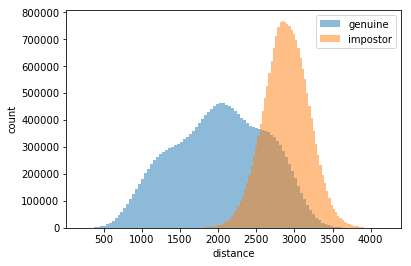

In [13]:
genuine,impostor =[],[]
def plotHistogram():
    dataMatBinary,labelMatBinary = [],[]
    for i in range(len(label)):
        if label[i]==0 or label[i]==1:
            dataMatBinary.append(data.iloc[i])
            labelMatBinary.append(label[i])
    dists = sklearn.metrics.pairwise.euclidean_distances(dataMatBinary)
    for (i_index,i),(j_index,j) in itertools.combinations(enumerate(labelMatBinary), 2):
        genuine.append(dists[i_index][j_index]) if i==j else impostor.append(dists[i_index][j_index])
    bins = 100
    labels = plt.subplot()
    labels.set_xlabel("distance")
    labels.set_ylabel("count")
    plt.hist(genuine, bins, alpha=0.5, label='genuine')
    plt.hist(impostor, bins, alpha=0.5, label='impostor')
    plt.legend(loc='upper right')
    plt.show()
    return dists
    
dists = plotHistogram()

equal error rate:  0.810559000136914
guess rate:  0.4980962783079905


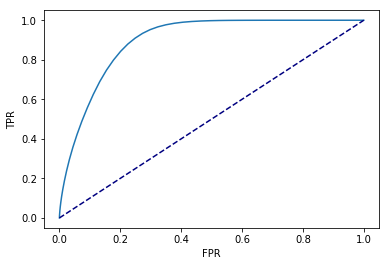

In [25]:
def plotROC(genuine,impostor):
    tprarray,fprarray = [],[]
    genuine = np.array(genuine)
    impostor = np.array(impostor)
    for distance in range(int(amin(dists)),int(amax(dists)),50):
        tp = len(impostor[impostor>= distance])
        fp = len(genuine[genuine>= distance])
        fn = len(impostor) - tp
        tn = len(genuine) - fp
        tpr = tp / len(impostor)
        fpr = fp / len(genuine)
        tprarray.append( tpr )
        fprarray.append( fpr )
        if abs(fpr-1+tpr) < 0.03:
            eer = (tp+tn)/(tp+tn+fn+fp)
            print("equal error rate: ",eer)
    print("guess rate: ",len(impostor)/(len(impostor)+len(genuine)))
    
    plt.plot(fprarray,tprarray)
    plt.plot([0,1],[0,1],color='navy',linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
plotROC(genuine,impostor)

In [2]:
def nearestNeighborK(inX, dataMat, labelMat, k):
    dataSetSize = dataMat.shape[0]
    diffMat = tile(inX,(dataSetSize,1)) - dataMat
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()
    classCount={}
    for i in range(1,k+1):
        voteIlabel = labelMat[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
    return max(classCount, key=classCount.get)

from sklearn.metrics import confusion_matrix
from sklearn import cross_validation

def evaluate(*fold):
    # Evaluate an SVM classifier
    train_indices, test_indices, k = fold
    local_data = np.array(data)
    local_label = np.array(label)
    X_train = local_data[train_indices]
    Y_train = local_label[train_indices]
    X_test = local_data[test_indices]
    Y_test = local_label[test_indices]
    success = 0
    Y_pred = []
    for i in range(0,len(X_test)):
        Y_pred.append(nearestNeighborK(X_test[i],X_train,Y_train,k))
        success+= (Y_pred[i]==Y_test[i])
    print(confusion_matrix(array(Y_pred), Y_test))
    return float(success)/len(X_test)

def performCrossValidation(sampleSize = 1000):
    size = len(data)
    if sampleSize != 0:
        size = sampleSize

    for train, test in (cross_validation.KFold(size, n_folds=3)):
        for k in range(3,13,2):
            print("\n\nK is :", k)
            print(evaluate(train,test,k), " is the success rate")

def printConfusionMatrix(k=3,sampleSize=1000):
    size = len(data)
    if sampleSize != 0:
        size = sampleSize

    for train, test in (cross_validation.KFold(size, n_folds=k)):
        print("K is :", k)
        print(evaluate(train,test,k) , " is the success rate")

printConfusionMatrix(k=3,sampleSize=1000)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


K is : 3
[[40  0  1  0  0  0  1  0  0  0]
 [ 0 33  4  1  0  1  1  2  1  1]
 [ 0  0 27  1  0  0  1  0  0  0]
 [ 0  0  1 26  0  4  0  0  4  0]
 [ 0  0  0  0 27  0  1  1  0  2]
 [ 0  0  1  3  0 16  1  0  0  0]
 [ 3  0  1  1  0  3 27  0  0  0]
 [ 0  0  1  1  0  0  0 28  1  6]
 [ 0  0  0  1  1  0  0  0 19  1]
 [ 0  0  1  1  3  1  0  3  2 27]]
0.8083832335329342  is the success rate
K is : 3
[[27  0  1  0  0  0  1  0  0  1]
 [ 0 34  3  0  1  1  1  2  2  1]
 [ 0  1 37  0  0  0  0  0  0  1]
 [ 0  0  0 23  0  3  0  0  5  0]
 [ 0  0  1  0 26  0  0  0  0  2]
 [ 0  0  0  2  0 33  0  0  1  0]
 [ 0  0  0  0  1  0 27  0  1  0]
 [ 0  0  4  1  4  0  0 22  1  2]
 [ 0  0  1  0  0  0  0  0 20  0]
 [ 0  0  1  0  8  0  0  5  1 24]]
0.8198198198198198  is the success rate
K is : 3
[[36  0  1  0  0  0  1  0  0  1]
 [ 0 27  1  1  1  0  0  3  4  1]
 [ 0  0 34  1  0  0  0  0  0  1]
 [ 0  0  0 22  0  3  0  0  2  0]
 [ 0  0  0  0 22  0  0  1  0  1]
 [ 0  0  0  2  0 22  0  0  3  1]
 [ 1  0  0  0  2  0 35  0  0  0]
